In [6]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import collections
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import openml

from optuna_kfoldCV import evaluate_dataset_with_model, run_all_openML_with_model
from regression_param_specs import evaluate_Ridge, evaluate_XGBoostRegressor

np.set_printoptions(precision=3, threshold=5) # Print options

# How to run an experiment

In [7]:
# !python regression_param_specs.py \
#     --models Ridge \
#     --dataset_indices 0 1 2 \
#     --save_dir /home/USERNAME/Code/RFRBoost-sup-mat/save/OpenMLRegression/ \
#     --n_optuna_trials 100 \
#     --device cpu \
#     --k_folds 5 \
#     --cv_seed 42

# join json results

In [8]:
import json
import os
import numpy as np
import pandas as pd

from optuna_kfoldCV import openML_reg_ids


def read_json(path):
    with open(path, "r") as f:
        return json.load(f)
    


def custom_deep_update(original, update):
    for key, value in update.items():
        if isinstance(value, dict) and key in original:
            custom_deep_update(original[key], value)
        else:
            original[key] = value



def get_joined_results_json(
        models: List[str],
        datasets = openML_reg_ids,
        save_dir = "/home/USERNAME/Code/RFRBoost-sup-mat/save/OpenMLRegression/",
        ):
    results_json = {}
    for model in models:
        for dataset in datasets:
            path = os.path.join(save_dir, f"regression_{dataset}_{model}.json")
            #print(path)
            res = read_json(path)
            if results_json == {}:
                results_json = res
            else:
                custom_deep_update(results_json, res)
    return results_json



def join_jsons_into_array(
        results_json,
        ):
    results = []
    for dataset, dataset_results in results_json.items():
        res = []
        for model_name, model_results in dataset_results.items():
            model_res = np.stack([model_results["score_train"], model_results["score_test"], model_results["t_fit"], model_results["t_inference"]])
            res.append(model_res)
        results.append(res)
    return np.stack(results) # (n_datasets, n_models, 4, n_folds)


def results_to_df(
        models: List[str],
        datasets = openML_reg_ids[:],
        save_dir = "/home/USERNAME/Code/RFRBoost-sup-mat/save/OpenMLRegression/",
        ):
    # Load and join the JSON data
    results_json = get_joined_results_json(models, datasets, save_dir)
    results = join_jsons_into_array(results_json) # (n_datasets, n_models, 4, n_folds)
    
    # Calculate means and stds across folds
    results_mean = np.mean(results, axis=-1)  # (n_datasets, n_models, 4)
    results_std = np.std(results, axis=-1)    # (n_datasets, n_models, 4)
    
    # Create a dictionary to hold both mean and std DataFrames
    metrics = ["score_train", "score_test", "t_fit", "t_inference"]
    metric_dfs = {}
    
    # Initialize DataFrames for both mean and std metrics
    for metric in metrics:
        metric_dfs[metric] = pd.DataFrame(index=datasets, columns=models)
        metric_dfs[f"{metric}_std"] = pd.DataFrame(index=datasets, columns=models)
    
    # Populate the DataFrames for each metric
    for dataset_idx, dataset in enumerate(datasets):
        for model_idx, model in enumerate(models):
            for metric_idx, metric in enumerate(metrics):
                # Set mean value
                metric_dfs[metric].loc[dataset, model] = results_mean[dataset_idx, model_idx, metric_idx]
                # Set* std value
                metric_dfs[f"{metric}_std"].loc[dataset, model] = results_std[dataset_idx, model_idx, metric_idx]
    
    return metric_dfs


In [12]:
models = [
    "End2End_cpu",
    "Ridge",
    "XGBoostRegressor",
    "RFNN",
    "GreedyRFRBoostDiag_batchnormFalse",
    "GreedyRFRBoostScalar_batchnormFalse",
    "GradientRFRBoost_ID_batchnormFalse",
    "GreedyRFRBoostDense_ID_batchnormFalse",
]
save_dir = "/home/USERNAME/Code/RFRBoost-sup-mat/save/OpenMLRegression/"

In [10]:
df = results_to_df(        
    models = models,
    datasets = openML_reg_ids[[i for i in range(len(openML_reg_ids)) if i not in []]],
    save_dir=save_dir,
    )


In [11]:
df["score_test"].mean().sort_values(ascending=True)

XGBoostRegressor                          0.39544
GradientRFRBoost_ID_batchnormFalse       0.408568
GreedyRFRBoostDense_ID_batchnormFalse    0.409401
GreedyRFRBoostDiag_batchnormFalse        0.415229
End2End_cpu                              0.416709
GreedyRFRBoostScalar_batchnormFalse      0.433258
RFNN                                     0.433955
Ridge                                    0.539519
dtype: object

In [12]:
df["t_fit"].mean().sort_values(ascending=True)

Ridge                                      0.00095
RFNN                                      0.044202
GreedyRFRBoostScalar_batchnormFalse       0.638085
GreedyRFRBoostDiag_batchnormFalse         0.918357
GradientRFRBoost_ID_batchnormFalse        1.748811
XGBoostRegressor                          1.872937
GreedyRFRBoostDense_ID_batchnormFalse     2.888457
End2End_cpu                              38.908994
dtype: object

In [13]:
df["score_test"].rank(axis=1).mean().sort_values()

GradientRFRBoost_ID_batchnormFalse       2.558824
GreedyRFRBoostDense_ID_batchnormFalse    2.852941
XGBoostRegressor                         3.205882
GreedyRFRBoostDiag_batchnormFalse        4.117647
End2End_cpu                              4.882353
GreedyRFRBoostScalar_batchnormFalse      5.558824
RFNN                                     5.647059
Ridge                                    7.176471
dtype: float64

# Print results

In [14]:
df_renamed = {k:v for k,v in df.items()}
print(df_renamed["score_test"].columns)
for key in df_renamed.keys():
    df_renamed[key] = df_renamed[key].rename(columns={
        "End2End_cpu": "E2E MLP ResNet",
        "Ridge": "Ridge Regression",
        "XGBoostRegressor": "XGBoost",
        "RFNN": "RFNN",
        "GreedyRFRBoostScalar_batchnormFalse": "Greedy RFRBoost $\Delta_{scalar}$",
        "GreedyRFRBoostDiag_batchnormFalse": "Greedy RFRBoost $\Delta_{diag}$",
        "GreedyRFRBoostDense_ID_batchnormFalse": "Greedy RFRBoost $\Delta_{dense}$",
        "GradientRFRBoost_ID_batchnormFalse": "Gradient RFRBoost",
        })
print(df_renamed["score_test"].columns)

Index(['End2End_cpu', 'Ridge', 'XGBoostRegressor', 'RFNN',
       'GreedyRFRBoostDiag_batchnormFalse',
       'GreedyRFRBoostScalar_batchnormFalse',
       'GradientRFRBoost_ID_batchnormFalse',
       'GreedyRFRBoostDense_ID_batchnormFalse'],
      dtype='object')
Index(['E2E MLP ResNet', 'Ridge Regression', 'XGBoost', 'RFNN',
       'Greedy RFRBoost $\Delta_{diag}$', 'Greedy RFRBoost $\Delta_{scalar}$',
       'Gradient RFRBoost', 'Greedy RFRBoost $\Delta_{dense}$'],
      dtype='object')


/tmp/ipykernel_8295/3858347232.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


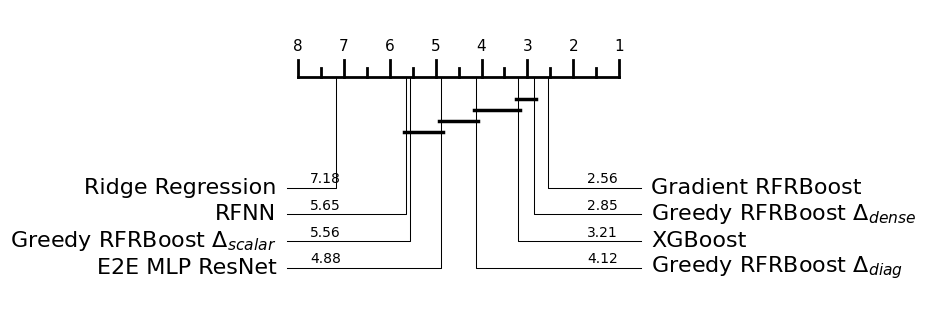

In [15]:
from aeon.visualisation import plot_critical_difference, plot_significance
import matplotlib.pyplot as plt

# Generate the plot
plot = plot_critical_difference(df_renamed["score_test"].values,
                                df_renamed["score_test"].columns.tolist(), 
                                alpha=0.10, 
                                lower_better=True,
                                digits=2,
                                width=7, #default 6
                                textspace=2.0, #default 1.5
                                )

# Retrieve the figure and axes from the plot
fig = plot[0].figure
ax = plot[0]

# Adjust figure size
fig.set_size_inches(6, 3)

# Adjust layout
fig.tight_layout()

# Save the figures
plot[0].savefig("results/OpenMLRegression/OpenMLReg_critical_difference.eps", bbox_inches='tight')
plot[0].savefig("results/OpenMLRegression/OpenMLReg_critical_difference.png", bbox_inches='tight')

In [24]:
import pandas as pd
import numpy as np

def create_latex_table(
        df_scores: pd.DataFrame, 
        df_t_fit: pd.DataFrame, 
        decimals: int = 3, 
        include_std: bool = False) -> str:
    table = """\\begin{table}[t]
\\caption{Average test RMSE and fit times on the OpenML regression tasks.}
\\label{tab:openml-regression}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & RMSE & Fit Time (s) \\\\
\\midrule
"""
    # Calculate means and stds
    score_means = df_scores.mean()
    score_stds = df_scores.std()
    time_means = df_t_fit.mean()
    time_stds = df_t_fit.std()
    
    # Create sorted index based on scores
    sorted_idx = score_means.sort_values(ascending=True).index
    
    # Create formatted rows
    for model in sorted_idx:
        if include_std:
            score_str = f"{score_means[model]:.{decimals}f} ({score_stds[model]:.{decimals}f})"
            time_str = f"{time_means[model]:.{decimals}f} ({time_stds[model]:.{decimals}f})"
        else:
            score_str = f"{score_means[model]:.{decimals}f}"
            time_str = f"{time_means[model]:.{decimals}f}"
        table += f"{model} & {score_str} & {time_str} \\\\\n"
    
    table += """\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table


#usage
latex_table = create_latex_table(df_renamed["score_test"], df_renamed["t_fit"])
print(latex_table)

\begin{table}[t]
\caption{Average test RMSE and fit times on the OpenML regression tasks.}
\label{tab:openml-regression}
\vskip 0.15in
\begin{center}
\begin{small}
\begin{sc}
\begin{tabular}{lcc}
\toprule
Model & RMSE & Fit Time (s) \\
\midrule
XGBoost & 0.395 & 1.873 \\
Gradient RFRBoost & 0.409 & 1.749 \\
Greedy RFRBoost $\Delta_{dense}$ & 0.409 & 2.888 \\
Greedy RFRBoost $\Delta_{diag}$ & 0.415 & 0.918 \\
E2E MLP ResNet & 0.417 & 38.909 \\
Greedy RFRBoost $\Delta_{scalar}$ & 0.433 & 0.638 \\
RFNN & 0.434 & 0.044 \\
Ridge Regression & 0.540 & 0.001 \\
\bottomrule
\end{tabular}
\end{sc}
\end{small}
\end{center}
\vskip -0.1in
\end{table}



# Usage example

In [11]:
import numpy as np
import torch
from models.random_feature_representation_boosting import GradientRFRBoostRegressor, GreedyRFRBoostRegressor
from sklearn.model_selection import train_test_split

# Generate toy data
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
n_samples = 2000
X = torch.randn(n_samples, 2)
y = X[:, 0] + X[:, 1]**2 + 0.1 * torch.randn(n_samples)
y = y.unsqueeze(1)  # Reshape y to (n_samples, 1) for regression

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

# 1. GradientRFRBoostRegressor
gradient_rfrboost = GradientRFRBoostRegressor(
    in_dim=2,
    out_dim=1,
    hidden_dim=64,
    n_layers=3,
    boost_lr=0.5,
    feature_type="SWIM",
    upscale_type="identity",
    l2_reg=0.001,
    l2_ghat=0.001
)

# Train and evaluate
gradient_rfrboost.fit(X_train, y_train)
y_pred_train_gradient = gradient_rfrboost(X_train)
y_pred_test_gradient = gradient_rfrboost(X_test)

train_rmse_gradient = torch.sqrt(torch.mean((y_pred_train_gradient - y_train)**2))
test_rmse_gradient = torch.sqrt(torch.mean((y_pred_test_gradient - y_test)**2))

print("GradientRFRBoostRegressor:")
print(f"  Train RMSE: {train_rmse_gradient:.4f}")
print(f"  Test RMSE:  {test_rmse_gradient:.4f}")

# 2. GreedyRFRBoostRegressor
greedy_rfrboost = GreedyRFRBoostRegressor(
    in_dim=2,
    out_dim=1,
    hidden_dim=64,
    n_layers=3,
    boost_lr=0.5,
    feature_type="SWIM",
    upscale_type="identity",
    sandwich_solver="dense",
    l2_reg=0.001,
    l2_ghat=0.001
)

# Train and evaluate
greedy_rfrboost.fit(X_train, y_train)
y_pred_train_greedy = greedy_rfrboost(X_train)
y_pred_test_greedy = greedy_rfrboost(X_test)

train_rmse_greedy = torch.sqrt(torch.mean((y_pred_train_greedy - y_train)**2))
test_rmse_greedy = torch.sqrt(torch.mean((y_pred_test_greedy - y_test)**2))

print("\nGreedyRFRBoostRegressor:")
print(f"  Train RMSE: {train_rmse_greedy:.4f}")
print(f"  Test RMSE:  {test_rmse_greedy:.4f}")

# Baseline: Naive prediction using mean
naive_train_rmse = torch.sqrt(torch.mean((y_train - y_train.mean())**2))
naive_test_rmse = torch.sqrt(torch.mean((y_test - y_train.mean())**2))

print("\nNaive (mean) baseline:")
print(f"  Train RMSE: {naive_train_rmse:.4f}")
print(f"  Test RMSE:  {naive_test_rmse:.4f}")

GradientRFRBoostRegressor:
  Train RMSE: 0.1736
  Test RMSE:  0.2599

GreedyRFRBoostRegressor:
  Train RMSE: 0.1813
  Test RMSE:  0.2921

Naive (mean) baseline:
  Train RMSE: 1.7043
  Test RMSE:  1.7306
